In [ ]:
## da mettere in files
# tag_max_freq
# tag_counter

# Table of Contents
 <p><div class="lev3 toc-item"><a href="#Create-basic-features" data-toc-modified-id="Create-basic-features-001"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Create basic features</a></div><div class="lev3 toc-item"><a href="#Create-features-after-tagger-(see-tagger-notebook)" data-toc-modified-id="Create-features-after-tagger-(see-tagger-notebook)-002"><span class="toc-item-num">0.0.2&nbsp;&nbsp;</span>Create features after tagger (see tagger notebook)</a></div><div class="lev3 toc-item"><a href="#Create-&quot;external&quot;-features" data-toc-modified-id="Create-&quot;external&quot;-features-003"><span class="toc-item-num">0.0.3&nbsp;&nbsp;</span>Create "external" features</a></div><div class="lev3 toc-item"><a href="#Create-bit-features" data-toc-modified-id="Create-bit-features-004"><span class="toc-item-num">0.0.4&nbsp;&nbsp;</span>Create bit features</a></div><div class="lev3 toc-item"><a href="#Some-features-with-word2vec" data-toc-modified-id="Some-features-with-word2vec-005"><span class="toc-item-num">0.0.5&nbsp;&nbsp;</span>Some features with word2vec</a></div><div class="lev3 toc-item"><a href="#Train-Xgboost-model" data-toc-modified-id="Train-Xgboost-model-006"><span class="toc-item-num">0.0.6&nbsp;&nbsp;</span>Train Xgboost model</a></div><div class="lev3 toc-item"><a href="#Bayesian-Optimization" data-toc-modified-id="Bayesian-Optimization-007"><span class="toc-item-num">0.0.7&nbsp;&nbsp;</span>Bayesian Optimization</a></div><div class="lev3 toc-item"><a href="#Make-Submission" data-toc-modified-id="Make-Submission-008"><span class="toc-item-num">0.0.8&nbsp;&nbsp;</span>Make Submission</a></div><div class="lev3 toc-item"><a href="#The-End" data-toc-modified-id="The-End-009"><span class="toc-item-num">0.0.9&nbsp;&nbsp;</span>The End</a></div>

In [1]:
import quoradefs as qd
from time import time
import gc
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from itertools import chain, combinations
from collections import Counter

from gensim.models import word2vec
import gensim

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pickle
import gc
import xgboost as xgb


from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

print(train_df.shape)
print(test_df.shape)

## adjusting the nan value
train_df.fillna("", inplace=True)
test_df.fillna("", inplace=True)
train_df.info()

(404290, 6)
(2345796, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


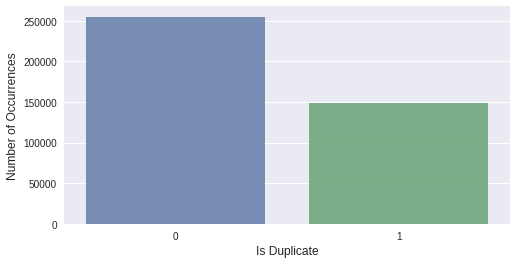

In [6]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

### Create basic features 

- word shared
- different characters/words length
- matching first/second/third/last word
- puntualization
- etc.

In [50]:
question1, question2 = 'question1', 'question2'
qd.create_diff_punteggiatura(train_df, question1, question2)
qd.create_diff_punteggiatura(test_df, question1, question2)

qd.add_clear_first(train_df, question1)
qd.add_clear_first(train_df, question2)
qd.add_clear_first(test_df, question1)
qd.add_clear_first(test_df, question2)

question1_tagg = question1 + '_clear_1'
question2_tagg = question2 + '_clear_1'

qd.add_clear_second(train_df, question1_tagg)
qd.add_clear_second(train_df, question2_tagg)

q1 = 'question1_clear_1_clear_2'
q2 = 'question2_clear_1_clear_2'

qd.create_add_vars(train_df, q1=q1, q2=q2)
qd.calc_match_capital(train_df, question1=q1, question2=q1)

qd.calc_match_capital(test_df, question1=q1, question2=q1)
qd.create_add_vars(test_df, q1=q1, q2=q2)

In [48]:
all_unique_quests = set(
    list(set(train_df[q1])) + list(set(train_df[q2])) + list(set(test_df[q1]))
    + list(set(test_df[q2])))
all_words = qd.flatmap(qd.get_words, all_unique_quests)
cnt_words = Counter(all_words)

In [342]:
all_unique_quests = list(
    set(
        list(set(train_df[q1])) + list(set(train_df[q2])) +
        list(set(test_df[q1])) + list(set(test_df[q2]))))
qcat = pd.Series(
    list(map(lambda x: (x.split()[0].lower()), list(
        all_unique_quests)))).value_counts()
qcat = (1 / (qcat)).to_dict()

qd.add_first_unique(train_df)
qd.add_first_unique(test_df)

### Create features after tagger (see tagger notebook)

- matching verbds, nouns, etc.
- rarity: different class of rarity

- sequences: matching structure of the phrase

In [24]:
work = pd.read_csv('tagged_list_counted_solved.csv', encoding='latin1', sep=';')

sym = work[work['tag_recod']=='SYM']
fw = work[work['tag_recod']=='FW']
uh = work[work['tag_recod']=='UH']
mo = work[work['tag_recod']=='MO']
noun = work[work['tag_recod']=='NOUN']
verb = work[work['tag_recod']=='VERB']
jj = work[work['tag_recod']=='JJ']

listverb = Counter(list(verb['name'].values))
listsym = Counter(list(sym['name'].values))
listuh = Counter(list(uh['name'].values))
listfw = Counter(list(fw['name'].values))
listnoun = Counter(list(noun['name'].values))
listjj = Counter(list(jj['name'].values))
listmo = Counter(list(mo['name'].values))

tag_list_vars = {
    '_VERB': listverb,
    '_NOUN': listnoun,
    '_FW': listfw,
    '_SYM': listsym,
    '_MO': listmo,
    '_JJ': listjj,
    '_UH': listuh
}

tag_rare_vars = {}
for cut in [(0,10), (10,50), (50,100), (100, 1000)]:
    tag_rare_vars[str(cut[0]) + '_' + str(cut[1])] = {
        '_VERB': Counter(list(verb[ (verb['count'] > cut[0]) & (verb['count']<= cut[1]) ]['name'].values)),
        '_NOUN': Counter(list(noun[ (noun['count'] > cut[0]) & (noun['count']<= cut[1]) ]['name'].values)),
        '_FW': Counter(list(fw[ (fw['count'] > cut[0]) & (fw['count']<= cut[1]) ]['name'].values)),
        '_JJ': Counter(list(jj[ (jj['count'] > cut[0]) & (jj['count']<= cut[1]) ]['name'].values))
    }

In [12]:
for tag_var in tag_list_vars.keys():
    train_df['count'+tag_var] = train_df.apply(axis=1, func = lambda x:
                                                      abs(qd.countword(x[q1], tag_list_vars[tag_var])
                                                          - qd.countword(x[q2], tag_list_vars[tag_var])))
    
for tag_var in tag_list_vars.keys():
    test_df['count'+tag_var] = test_df.apply(axis=1, func = lambda x:
                                                      abs(qd.countword(x[q1], tag_list_vars[tag_var])
                                                          - qd.countword(x[q2], tag_list_vars[tag_var])))
    
for cut in tag_rare_vars.keys():
    for tag_var in tag_rare_vars[cut]:
        train_df['rare'+cut +tag_var] = train_df.apply(axis=1, func = lambda x:
                                                      abs(qd.countword(x[q1], tag_rare_vars[cut][tag_var])
                                                          - qd.countword(x[q2], tag_rare_vars[cut][tag_var])))
        
for cut in tag_rare_vars.keys():
    for tag_var in tag_rare_vars[cut]:
        test_df['rare'+cut +tag_var] = test_df.apply(axis=1, func = lambda x:
                                                      abs(qd.countword(x[q1], tag_rare_vars[cut][tag_var])
                                                          - qd.countword(x[q2], tag_rare_vars[cut][tag_var])))
        
cut = '100_1000'
for tag_var in tag_rare_vars[cut]:
    train_df['rare'+cut +tag_var] = train_df.apply(axis=1, func = lambda x:
                                                 abs(qd.countword(x[q1], tag_rare_vars[cut][tag_var])
                                                     - qd.countword(x[q2], tag_rare_vars[cut][tag_var])))
    
cut = '100_1000'
for tag_var in tag_rare_vars[cut]:
    test_df['rare'+cut +tag_var] = test_df.apply(axis=1, func = lambda x:
                                                 abs(qd.countword(x[q1], tag_rare_vars[cut][tag_var])
                                                     - qd.countword(x[q2], tag_rare_vars[cut][tag_var])))

In [ ]:
listona_tag = [
    'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN',
    'NNS', 'NP', 'NPS', 'PDT', 'POS', 'PP', 'PP$', 'RB', 'RBR', 'RBS', 'RP',
    'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
    'WP$', 'WRB'
]

for tag in listona_tag:
    train_df[tag + '_diff'] = train_df.apply(
        axis=1, func=lambda x: abs(dizionario.get(x[q1], 'ciccia')[tag] - dizionario.get(x[q2], 'ciccia')[tag]))
    
for tag in listona_tag:
    test_df[tag + '_diff'] = test_df.apply(
        axis=1, func=lambda x: abs(dizionario.get(x[q1], 'ciccia')[tag] - dizionario.get(x[q2], 'ciccia')[tag]))

dizionario_max = qd.load_obj('tag_max_freq')

for i in ['JJ', 'FW', 'VERB', 'NOUN', 'SYM', 'MD', 'WRB', 'IN']:
    qd.calc_match_capital2(train_df, q1, q2, diz=dizionario_max, tipo=i)
    
for i in ['JJ', 'FW', 'VERB', 'NOUN', 'SYM', 'MD', 'WRB', 'IN']:
    qd.calc_match_capital2(test_df, q1, q2, diz=dizionario_max, tipo=i)
    
for t in ['VERB', 'NOUN', 'JJ', 'WRB']:
    train_df['seq_sim_' + t] = train_df.apply(
        axis=1, func=lambda x:qd. get_sequenceones_similarity(x[q1], x[q2], [t]))
train_df['seq_sim_tot'] = train_df.apply(axis=1, func = lambda x: qd.get_sequenceones_similarity(x[q1],x[q2]))

for t in ['VERB', 'NOUN', 'JJ', 'WRB']:
    test_df['seq_sim_' + t] = test_df.apply(
        axis=1, func=lambda x: qd.get_sequenceones_similarity(x[q1], x[q2], [t]))
test_df['seq_sim_tot'] = test_df.apply(axis=1, func = lambda x: qd.get_sequenceones_similarity(x[q1],x[q2]))

tempvar = train_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.get_sequenceones_similarity2(x[q1], x[q2])))
tempvar.columns = ['seq_sim1', 'seq_sim2']
train_df = pd.concat([train_df, tempvar], axis=1)

tempvar = test_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.get_sequenceones_similarity2(x[q1], x[q2])))
tempvar.columns = ['seq_sim1', 'seq_sim2']
test_df = pd.concat([test_df, tempvar], axis=1)

### Create "external" features

- maths
- SPOILER alert
- unknown words shared
- states shared
- citizen shared
- tvseries shared

In [ ]:
qd.get_diff_spoiler_math(train_df, q1, q2)
qd.get_diff_spoiler_math(test_df, q1, q2)

dizionario = qd.load_obj('tag_counter')
dizionario['ciccia'] = Counter()

serie = pd.read_csv('.\\files\\tvseries.txt')
serie = list(serie['name'].values)
states = pd.read_csv('.\\files\\states.txt')
states = list(states['name'].values)
citizen = pd.read_csv('.\\files\\citizen.txt')
citizen = list(citizen['name'].values)
serie = [n.lower() for n in serie]
states = [n.lower() for n in states]
citizen = [n.lower() for n in citizen]

english_vocab = set(w.lower() for w in nltk.corpus.words.words())

tempvar = train_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_unknown_variables(x[q1], x[q2], english_vocab)))
tempvar.columns = ['unk1', 'unk2', 'unk3']
train_df = pd.concat([train_df, tempvar], axis=1)

tempvar = train_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], serie)))
tempvar.columns = ['serie1', 'serie2', 'serie3']
train_df = pd.concat([train_df, tempvar], axis=1)

tempvar = train_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], states)))
tempvar.columns = ['states1', 'states2', 'states3']
train_df = pd.concat([train_df, tempvar], axis=1)

tempvar = train_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], citizen)))
tempvar.columns = ['citizen1', 'citizen2', 'citizen3']
train_df = pd.concat([train_df, tempvar], axis=1)

tempvar = test_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_unknown_variables(x[q1], x[q2])))
tempvar.columns = ['unk1', 'unk2', 'unk3']
test_df = pd.concat([test_df, tempvar], axis=1)

tempvar = test_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], serie)))
tempvar.columns = ['serie1', 'serie2', 'serie3']
test_df = pd.concat([test_df, tempvar], axis=1)

tempvar = test_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], states)))
tempvar.columns = ['states1', 'states2', 'states3']
test_df = pd.concat([test_df, tempvar], axis=1)

tempvar = test_df.apply(
    axis=1,
    func=
    lambda x: qd.getback_function(qd.get_variables_from_lists(x[q1], x[q2], citizen)))
tempvar.columns = ['citizen1', 'citizen2', 'citizen3']
test_df = pd.concat([test_df, tempvar], axis=1)

### Create bit features

In [63]:
loc_time = ['as', 'of', 'for', 'up', 'down', 'out', 'on', 'off', 'over', 'under', 'again', 'so',
'too', 'very', 'few', 'more', 'most']

for i in loc_time:
    train_df[i+'_or'] = train_df.apply(axis=1, func=lambda x: qd.get_bit_single_word(x[q1], i) or qd.get_bit_single_word(x[q2], i))
    train_df[i+'_and'] = train_df.apply(axis=1, func=lambda x: qd.get_bit_single_word(x[q1], i) and qd.get_bit_single_word(x[q2], i))

for i in loc_time:
    test_df[i+'_or'] = test_df.apply(axis=1, func=lambda x: qd.get_bit_single_word(x[q1], i) or qd.get_bit_single_word(x[q2], i))
    test_df[i+'_and'] = test_df.apply(axis=1, func=lambda x: qd.get_bit_single_word(x[q1], i) and qd.get_bit_single_word(x[q2], i))

### Some features with word2vec

- feature extraction using pca on words vector
- isomap after pca on difference between phrases
- W2V distances between phrases by removing a fraction of words

In [ ]:
train_df = pd.read_csv('train_clear.csv', usecols=(1,6,9,10))
test_df = pd.read_csv('test_clear.csv', usecols=(1,6,7))
train_df.fillna("ciccia", inplace=True)
test_df.fillna("ciccia", inplace=True)

In [ ]:
q1, q2 = 'question1_final', 'question2_final'

corpus = qd.build_corpus(train_df, q1, q2)
corpus.extend(qd.build_corpus(test_df, q1, q2))

In [ ]:
model = word2vec.Word2Vec(
    corpus,
    size=135,
    window=10,
    min_count=5,
    workers=8,
    sg=1,
    hs=1,
    negative=10,
    iter=10,
    sorted_vocab=-1)

model_50 = word2vec.Word2Vec(
    corpus,
    size=50,
    window=10,
    min_count=5,
    workers=8,
    sg=1,
    hs=1,
    negative=10,
    iter=10,
    sorted_vocab=-1)

model_50.save('model_best_50.bin')
model_50.wv.save_word2vec_format('model_best_format_50.bin')

model.save('model_best.bin')
model.wv.save_word2vec_format('model_best_format.bin')

In [ ]:
train_df = pd.read_csv('.\\train_clear.csv', encoding='latin1')

q1 = 'question1_final'
q2 = 'question2_final'

train_df.fillna('ciccia', inplace=True)

all_unique_quests = set(list(set(train_df[q1])) + list(set(train_df[q2])))
all_words = qd.flatmap(qd.get_words, all_unique_quests)
cnt_words = Counter(all_words)

cnt_most = cnt_words.most_common(200)
cnt_most = [cnt_most[i][0] for i in range(0, 200)]

model = gensim.models.KeyedVectors.load('./model_best_50.bin')

#train
all_train = train_df[['id', q1, q2]].values
b = list(map(qd.clear_phrase, all_train))

results = []
step = 5000

for i in range(0, len(b), step):  #len(b)
    x = time.clock()
    results.extend(list(map(qd.get_phrase_distances2, b[i:i + step])))
    y = time.clock() - x
    print(str(i) + '/404290 e ci ho impiegato ' + str(y / 60) + ' minuti')

myres = np.array(results)
temp = train_df.apply(axis=1, func=lambda x: qd.getback_function(myres[x['id']]))
temp.columns = ['dist_' + str(i) for i in range(0, 10)]
train_df = pd.concat([train_df, temp], axis=1)

train_df.replace(np.inf, np.nan, inplace=True)

ftrs = list(
    set(train_df.columns) - set([
        'Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
        'question1_clear_1', 'question2_clear_1', 'question1_final',
        'question2_final'
    ]))

train_df[ftrs].to_csv('train_dist_vars.csv')

for n in temp.columns:
    print(n)
    qd.plot_variable(train_df[np.isfinite(train_df['dist_0'])], n)

# test
all_test = test_df[['test_id', q1, q2]].values
b = list(map(qd.clear_phrase, all_test))

results = []
step = 5000

for i in range(0, len(b), step):  #len(b)
    x = time.clock()
    results.extend(list(map(qd.get_phrase_distances2, b[i:i + step])))
    y = time.clock() - x
    print(str(i) + '/2345796 e ci ho impiegato ' + str(y / 60) + ' minuti')

myres = np.array(results)
temp = test_df.apply(axis=1, func=lambda x: qd.getback_function(myres[x['id']]))
temp.columns = ['dist_' + str(i) for i in range(0, 10)]
test_df = pd.concat([test_df, temp], axis=1)
test_df.replace(np.inf, np.nan, inplace=True)

ftrs = list(
    set(test_df.columns) - set([
        'Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
        'question1_clear_1', 'question2_clear_1', 'question1_final',
        'question2_final'
    ]))

test_df[ftrs].to_csv('test_dist_vars.csv')

In [ ]:
tempvar = train_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.pca_vars(x[q1], x[q2])))
tempvar.columns = ['diff_eigenv_pca', 'cos_pca', 'diff_ratio_ecc_pca']
train_df = pd.concat([train_df, tempvar], axis=1)
train_df.fillna(0, inplace=True)

tempvar = test_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.pca_vars(x[q1], x[q2])))
tempvar.columns = ['diff_eigenv_pca', 'cos_pca', 'diff_ratio_ecc_pca']
test_df = pd.concat([test_df, tempvar], axis=1)
test_df.fillna(0, inplace=True)

tempvar = train_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.get_W2V_variables(x[q1], x[q2], model)))
tempvar.columns = ['norm_mean_wv', 'norm_sum_wv', 'cos_mean_wv', 'cos_sum_wv']
train_df = pd.concat([train_df, tempvar], axis=1)
train_df.replace(np.inf, np.nan,inplace=True)
train_df.fillna(0, inplace=True)

tempvar = test_df.apply(
    axis=1, func=lambda x: qd.getback_function(qd.get_W2V_variables(x[q1], x[q2], model)))
tempvar.columns = ['norm_mean_wv', 'norm_sum_wv', 'cos_mean_wv', 'cos_sum_wv']
test_df = pd.concat([test_df, tempvar], axis=1)
test_df.replace(np.inf, np.nan,inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
v1 = train.apply(axis=1,func=lambda x: qd.getback_function([qd.get_W2V_sum_sentence(x.question1_final,model)]))
v2 = train.apply(axis=1,func=lambda x: qd.getback_function([qd.get_W2V_sum_sentence(x.question2_final,model)]))

v3 = test.apply(axis=1,func=lambda x: qd.getback_function([qd.get_W2V_sum_sentence(x.question1_final,model)]))
v4 = test.apply(axis=1,func=lambda x: qd.getback_function([qd.get_W2V_sum_sentence(x.question2_final,model)]))

name = ['diff_' + str(i) for i in range(0, 50)]

train_diff = pd.DataFrame(v1 - v2)
train_diff.columns = name
train = pd.concat([train, train_diff], axis=1)

test_diff = pd.DataFrame(np.abs(v3 - v4))
test_diff.columns = name
test = pd.concat([test, test_diff], axis=1)

train = np.abs(train)
test = np.abs(test)

traintestpca = pd.concat([train, test], axis=0).drop('Unnamed: 0', axis=1)

pca = PCA(n_components=50)
pca_diff = pca.fit_transform(traintestpca)

pca1_train = pca_diff[:404290, 1]
pca2_train = pca_diff[:404290, 2]
pca3_train = pca_diff[:404290, 3]
pca1_test = pca_diff[404290:, 1]
pca2_test = pca_diff[404290:, 2]
pca3_test = pca_diff[404290:, 3]

train_df['pca1'] = pca1_train
train_df['pca2'] = pca2_train
train_df['pca3'] = pca3_train

X_iso_fit = Isomap(
    n_neighbors=30, n_components=3).fit(traintestpca.sample(n=1000))

step = 50000
iso_all = []
for i in range(0, 404290, step):
    iso_all.extend(
        X_iso_fit.transform(
            traintestpca[:404290].iloc[0 + i:i + step]))  # 2345796:
    print(i)

name = 'iso_map_pca'
for i in range(0, 3):
    j = name + '_' + str(i)
    train_df[j] = np.array(iso_all)[:404290, i]

qd.plot_variable(train_df[(train_df['pca1'] > -4) & (train_df['pca1'] < 4)],
                'pca1')
qd.plot_variable(train_df[(train_df['pca2'] > -4) & (train_df['pca2'] < 4)],
                'pca2')
qd.plot_variable(train_df[(train_df['pca3'] > -4) & (train_df['pca3'] < 4)],
                'pca3')
qd.plot_variable(train_df[(train_df['iso_map_pca_0'] > -10) &
                         (train_df['iso_map_pca_0'] < 10)], 'iso_map_pca_0')
qd.plot_variable(train_df[(train_df['iso_map_pca_1'] > -5) &
                         (train_df['iso_map_pca_1'] < 5)], 'iso_map_pca_1')
qd.plot_variable(train_df[(train_df['iso_map_pca_2'] > -5) &
                         (train_df['iso_map_pca_2'] < 5)], 'iso_map_pca_2')

test['pca1'] = pca1_test
test['pca2'] = pca2_test
test['pca3'] = pca3_test

traintestpca = traintestpca.iloc[404290:]

step = 100000
iso_all_test = []

for i in range(0, 2345796, step):
    iso_all_test.extend(
        X_iso_fit.transform(traintestpca.iloc[0 + i:i + step]))  # 2345796:
    print(i)

name = 'iso_map_pca'
for i in range(0, 3):
    j = name + '_' + str(i)
    test[j] = np.array(iso_all_test)[:, i]

### Train Xgboost model

In [3]:
df = train_df

In [7]:
n = 1500
e_start = 0.3
x = np.linspace(0,n,n)
eta_adaptive = e_start*(1- (x/(5+x)))
eta_adaptive[eta_adaptive<0.05] = 0.05

other_par = {
    'num_boost_round':n
    , 'early_stopping_rounds':50
    , 'verbose_eval':20
}

params = {
    'objective':'binary:logistic'
    , 'silent': 0
    , 'nthread':10
    , 'eta':0.05
    , 'eval_metric': 'logloss'
    , 'maximize':True
    , 'max_depth':15
    , 'min_child_weight': 15
    , 'colsample_bytree': 0.75
    , 'subsample': 0.5
    , 'gamma': 70
    , 'alpha': 5
}

In [8]:
eventuali = [
    'question1_clear_1', 'question2_clear_1', 'question1_clear_1_clear_2',
    'question1_clear_1_clear_2', 'question2_clear_1_clear_2', 'question1_final', 'question2_final'
]
features = list(
    set(df.columns) -
    set(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'] +
        eventuali))

In [17]:
x_train = df[features+['is_duplicate']]

In [18]:
model_xgb, roc_auc_test, roc_auc_train, var_imp = train_xgboost_w(
    x_train, features, 'is_duplicate', params, other_par)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields dist_7, dist_5, dist_0, cos_pca, dist_2, dist_9, dist_6, dist_8, dist_4, dist_3, dist_1

### Bayesian Optimization

In [12]:
other_par = {
    'num_boost_round':1500
    , 'early_stopping_rounds':50
    , 'verbose_eval':False
}

params = {
    'objective':'binary:logistic'
    , 'silent': 0
    , 'nthread':10
    , 'eta':0.02
    , 'eval_metric': 'logloss'
    , 'maximize':True
}

myranges = {
    'min_child_weight': (1, 250),
    'colsample_bytree': (0.5, 1),
    'max_depth': (14, 25),
    'subsample': (0.5, 1),
    'gamma': (0, 300),
    'alpha': (0, 100)
}

In [10]:
target = 'is_duplicate'
df = df.sample(frac=1)
X_train, X_test, y_train, y_test = qd.train_test_split(
    df[features], df[target], test_size=0.33, random_state=786)
r = df[target].value_counts()[0]/df[target].value_counts()[1]
r = 1./0.165
w_train = y_train*r
w_train[y_train == 0] = 1
w_test = y_test*r
w_test[y_test == 0] = 1  
xg_train = xgb.DMatrix(X_train, label=y_train, weight=w_train)
xg_test = xgb.DMatrix(X_test, label=y_test, weight=w_test)
watchlist = [(xg_train, 'train'), (xg_test, 'test')]

In [11]:
xgbBO = qd.go_with_BayesianOptimization(
    xg_train,
    xg_test,
    watchlist,
    kappa=4,
    init_points=10,
    num_iter=150,
    params=params,
    other_par=other_par,
    myranges=myranges,
    sgn=-1)

Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 22m56s |   -0.34066 |   30.2880 |             0.9175 |  110.4182 |      7.1815 |            12.9789 |      0.8514 | 
    2 | 36m23s |   -0.34373 |   80.8833 |             0.5971 |   72.5274 |     10.3191 |            15.4048 |      0.5227 | 
    3 | 23m45s |   -0.34761 |   75.2651 |             0.6445 |  143.2929 |      8.4753 |            23.7030 |      0.8974 | 
    4 | 36m27s |   -0.33832 |   62.8072 |             0.8326 |   90.3208 |     11.3920 |            66.0692 |      0.9088 | 
    5 | 20m05s |   -0.36143 |   84.4648 |             0.7767 |  276.1428 |     11.7368 |            16.7507 |      0.7673 | 
    6 | 38m00s |   -0.33072 |   64.3275 |             0.7923 |   49.6461 |     10.6945 |            27.9142 |  

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.15478802e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
   11 | 26m17s |   -0.31815 |    0.6696 |             0.9308 |    1.6009 |      8.2270 |           248.3678 |      0.7654 | 
   12 | 25m24s |   -0.32258 |   99.1646 |             0.5584 |    8.2901 |      7.9599 |           249.6885 |      0.9099 | 
   13 | 15m33s |   -0.32439 |    0.3517 |             0.5659 |    2.8390 |     14.8680 |             4.3856 |      0.5030 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.63214935e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   14 | 17m50s |   -0.32838 |    8.5788 |             0.9738 |    1.8492 |      5.0337 |           126.4519 |      0.5969 | 
   15 | 45m41s |   -0.34145 |    3.7402 |             0.8735 |  110.0126 |     14.7778 |           248.5686 |      0.5632 | 
   16 | 09m47s |   -0.36625 |   99.2722 |             0.7380 |  294.7368 |      5.3590 |           247.3311 |      0.6702 | 
   17 | 47m23s |   -0.31171 |   93.1871 |             0.7402 |    0.7411 |     14.7669 |           108.5365 |      0.9173 | 
   18 | 21m18s |   -0.32653 |   97.2299 |             0.6708 |    1.5833 |      5.5776 |            55.2902 |      0.6512 | 
   19 | 43m10s |   -0.31552 |   60.8743 |             0.7919 |    0.3971 |     14.4955 |           195.3390 |      0.5771 | 
   20 | 45m48s |   -0.31318 |   99.8837 |             0.6491 |    2.8798 |     14.9283 |           153.3007 |      0.9968 | 
   21 | 50m05s |   -0.30856 |   45.3265 |             0.9738 |    2.1108 |     14.8426 |            71.1777 |      0.8064 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.06363068e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 26m18s |   -0.35990 |    0.2062 |             0.7408 |  299.6955 |     14.6219 |           246.3253 |      0.6300 | 
   29 | 28m58s |   -0.35542 |   99.0846 |             0.6269 |  146.7525 |     14.8328 |           247.1198 |      0.5897 | 
   30 | 49m22s |   -0.30913 |   53.3951 |             0.8917 |    0.2078 |     14.9422 |            32.6846 |      0.8744 | 
   31 | 51m24s |   -0.34326 |    0.1021 |             0.6005 |  156.9008 |     14.7436 |            95.1311 |      0.7324 | 
   32 | 43m48s |   -0.30943 |   54.8727 |             0.6310 |    0.8879 |     14.4522 |           114.8393 |      0.9980 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.99722549e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   33 | 42m55s |   -0.31887 |   93.1281 |             0.5413 |    0.4951 |     14.9974 |           245.7469 |      0.6142 | 
   34 | 46m52s |   -0.31877 |   13.1527 |             0.9981 |   38.0240 |     14.7632 |           214.8538 |      0.8860 | 
   35 | 45m24s |   -0.30844 |    5.4838 |             0.7620 |    3.3574 |     14.9620 |           175.8215 |      0.9743 | 
   36 | 46m26s |   -0.30919 |   47.9023 |             0.7800 |    2.8984 |     14.9278 |           151.2222 |      0.9774 | 
   37 | 45m57s |   -0.32931 |   59.7161 |             0.6971 |   33.0900 |     14.9995 |           142.7598 |      0.5602 | 
   38 | 54m39s |   -0.34550 |    2.5252 |             0.7673 |  169.8156 |     14.4513 |             1.1195 |      0.7219 | 
   39 | 49m58s |   -0.30771 |   28.2608 |             0.5847 |    6.4338 |     14.8763 |            45.7781 |      0.9069 | 
   40 | 45m31s |   -0.31155 |   29.8622 |             0.6408 |    1.2015 |     14.3428 |           186.4499 |      0.6210 | 


KeyboardInterrupt: 

In [13]:
xgbBO = qd.go_with_BayesianOptimization(
    xg_train,
    xg_test,
    watchlist,
    kappa=4,
    init_points=10,
    num_iter=150,
    params=params,
    other_par=other_par,
    myranges=myranges,
    sgn=-1)

Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 39m06s |   -0.35439 |   40.9091 |             0.8879 |  209.7051 |     14.7205 |           209.1722 |      0.7074 | 
    2 | 47m55s |   -0.34504 |   47.2878 |             0.9610 |  119.4465 |     15.3950 |           135.2350 |      0.6957 | 
    3 | 43m39s |   -0.32722 |   35.9217 |             0.6858 |   34.2860 |     15.1360 |           241.8153 |      0.5349 | 
    4 | 56m28s |   -0.33521 |   33.1134 |             0.5365 |   89.7676 |     19.0541 |           117.0763 |      0.8600 | 
    5 | 22m59s |   -0.36261 |   95.6889 |             0.9369 |  267.1396 |     14.0558 |           231.3146 |      0.7032 | 
    6 | 64m28s |   -0.34798 |   37.6857 |             0.5635 |  155.4990 |     21.6794 |            44.4108 |  

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.53294692e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.55037043e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.15748522e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:42

   13 | 59m56s |   -0.30812 |    5.8836 |             0.9930 |    0.0201 |     22.5715 |           155.1168 |      0.7922 | 
   14 | 66m22s |   -0.30771 |    0.7909 |             0.8192 |    0.6420 |     23.2454 |           221.3153 |      0.9933 | 
   15 | 31m55s |   -0.36133 |   98.9739 |             0.5986 |  299.4269 |     20.4427 |             4.4245 |      0.9434 | 
   16 | 49m34s |   -0.30837 |   10.5616 |             0.6250 |    0.1537 |     24.5326 |            96.2393 |      0.7614 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2.45236079e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   17 | 52m08s |   -0.31441 |   96.2783 |             0.6723 |    0.5884 |     23.8512 |           243.4796 |      0.8714 | 
   18 | 57m42s |   -0.31008 |   37.7618 |             0.6447 |    0.3201 |     24.3899 |           186.3127 |      0.7086 | 
   19 | 55m35s |   -0.31204 |   14.7288 |             0.6732 |    0.8867 |     24.3769 |           248.4960 |      0.5310 | 
   20 | 66m17s |   -0.30964 |    3.9783 |             0.5737 |    0.4043 |     24.5980 |           182.1146 |      0.5926 | 
   21 | 62m20s |   -0.30946 |   73.9897 |             0.5608 |    0.3025 |     24.4239 |            99.7665 |      0.9610 | 
   22 | 73m01s |   -0.31141 |   99.8335 |             0.5765 |    2.1759 |     23.2525 |             7.0532 |      0.7080 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00019033]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -4.33475152e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   23 | 46m33s |   -0.31138 |   98.9621 |             0.5712 |    1.1259 |     14.0705 |            58.3244 |      0.9225 | 
   24 | 49m06s |   -0.30967 |   40.5088 |             0.6906 |    1.3559 |     15.4265 |           117.2166 |      0.7209 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.26219243e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   25 | 63m13s |   -0.31011 |   44.7346 |             0.8490 |    0.2750 |     24.7136 |            68.4267 |      0.6126 | 
   26 | 62m41s |   -0.30843 |   41.3380 |             0.9789 |    1.0484 |     24.6976 |           132.1144 |      0.8146 | 
   27 | 55m50s |   -0.30910 |    2.6147 |             0.8540 |    1.0764 |     24.7126 |           135.0514 |      0.5874 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011016]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 44m34s |   -0.35675 |    0.2699 |             0.7420 |  292.0935 |     20.2122 |             2.6155 |      0.7605 | 
   29 | 66m37s |   -0.31221 |   98.0954 |             0.5113 |    0.5087 |     23.9113 |            42.6436 |      0.7495 | 
   30 | 45m39s |   -0.30904 |    9.3252 |             0.9185 |    0.3846 |     14.8397 |           221.6919 |      0.9531 | 
   31 | 50m56s |   -0.30814 |   27.2849 |             0.5164 |    0.6085 |     15.5688 |           153.1154 |      0.8479 | 
   32 | 42m04s |   -0.31012 |    2.0498 |             0.9014 |    0.8738 |     14.3822 |           247.4683 |      0.9685 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.12932861e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   33 | 62m07s |   -0.30884 |   58.5612 |             0.8830 |    0.0770 |     24.7369 |           147.9597 |      0.9621 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017757]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   34 | 44m26s |   -0.30812 |    0.3357 |             0.6579 |    0.6736 |     14.0217 |            94.7632 |      0.8891 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0002341]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   35 | 42m35s |   -0.31819 |   95.6468 |             0.8181 |    1.3811 |     14.1107 |           118.6550 |      0.5341 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.89216033e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   36 | 52m02s |   -0.31063 |   69.8374 |             0.8851 |    0.1619 |     15.3553 |            28.0674 |      0.6940 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  1.86705402e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   37 | 44m14s |   -0.30869 |   41.5699 |             0.7984 |    0.3015 |     14.0881 |            87.4885 |      0.9978 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00073698]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   38 | 55m59s |   -0.30902 |   66.3239 |             0.9282 |    0.0420 |     18.4651 |            72.1133 |      0.9777 | 
   39 | 46m08s |   -0.31010 |    9.7401 |             0.7009 |    0.3059 |     14.2532 |           112.4993 |      0.5290 | 
   40 | 39m58s |   -0.30833 |    0.2566 |             0.6293 |    0.0413 |     14.5258 |            68.2951 |      0.7891 | 
   41 | 63m20s |   -0.30768 |   40.1063 |             0.9711 |    0.8375 |     23.8364 |           155.1179 |      0.9538 | 
   42 | 47m20s |   -0.30742 |   22.8385 |             0.6601 |    0.8411 |     15.3924 |            75.9327 |      0.8937 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00091882]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   43 | 46m34s |   -0.30978 |    0.0240 |             0.7927 |    0.3399 |     14.2585 |           162.0086 |      0.6920 | 
   44 | 49m40s |   -0.31584 |   71.1312 |             0.8211 |    0.0390 |     24.9970 |           212.3112 |      0.6052 | 
   45 | 41m55s |   -0.30872 |    2.5027 |             0.9023 |    1.3560 |     23.8367 |            77.8532 |      0.7399 | 
   46 | 66m36s |   -0.30748 |   26.7218 |             0.6785 |    0.7371 |     24.7548 |           167.1256 |      0.9742 | 
   47 | 47m35s |   -0.30963 |   94.6468 |             0.6948 |    1.1237 |     14.1094 |            15.2666 |      0.9577 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -2.22679721e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   48 | 43m36s |   -0.30770 |    7.6408 |             0.9449 |    0.0396 |     15.0925 |            85.8072 |      0.8853 | 
   49 | 60m21s |   -0.30721 |   22.6943 |             0.7216 |    1.1096 |     24.6520 |           151.9854 |      0.9805 | 
   50 | 41m32s |   -0.30804 |   22.7657 |             0.9886 |    0.6089 |     15.2693 |            62.2829 |      0.9661 | 
   51 | 43m32s |   -0.30775 |    7.1888 |             0.6709 |   14.0725 |     14.0497 |            78.9252 |      0.9636 | 
   52 | 73m20s |   -0.31141 |    0.1914 |             0.7702 |   33.2041 |     24.8587 |           131.6590 |      0.9561 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013552]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   53 | 72m23s |   -0.31119 |    0.0571 |             0.8954 |   34.5318 |     23.6798 |            88.0164 |      0.9706 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00027982]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


   54 | 66m07s |   -0.30902 |   26.6233 |             0.5966 |   14.4848 |     24.2913 |           148.9095 |      0.9995 | 
   55 | 50m42s |   -0.30793 |    1.6068 |             0.6985 |   18.3976 |     15.5233 |           101.1254 |      0.8895 | 
   56 | 64m20s |   -0.30845 |   53.1303 |             0.9457 |    0.3448 |     24.9161 |            99.8781 |      0.8858 | 
   57 | 70m16s |   -0.30800 |   25.6143 |             0.7789 |   14.5492 |     24.1640 |            91.4880 |      0.9838 | 
   58 | 70m19s |   -0.30951 |   23.7674 |             0.9166 |   18.9148 |     24.8147 |           113.0227 |      0.9846 | 


/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.62047685e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   59 | 54m07s |   -0.30795 |   26.4134 |             0.8794 |    0.0068 |     23.9872 |            97.8655 |      0.9193 | 


KeyboardInterrupt: 

In [16]:
## RETRAIN THE BEST MODEL HERE AFTER BAYEASIAN OPTIMIZATION
n = 1500

other_par = {
    'num_boost_round':n
    , 'early_stopping_rounds':50
    , 'verbose_eval':20
}

params = {
    'objective':'binary:logistic'
    , 'silent': 0
    , 'nthread':10
    , 'eta':0.02
    , 'eval_metric': 'logloss'
    , 'maximize':True
    , 'max_depth':15
    , 'min_child_weight': 45.7781
    , 'colsample_bytree': 0.5847
    , 'subsample': 0.9069
    , 'gamma': 6.4338 
    , 'alpha': 28.2608
}


retrain = train_xgboost(df, features, 'is_duplicate', params, other_par)

[0]	train-logloss:0.682476	test-logloss:0.682646
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[20]	train-logloss:0.533695	test-logloss:0.536705
[40]	train-logloss:0.453194	test-logloss:0.458528
[60]	train-logloss:0.406491	test-logloss:0.413945
[80]	train-logloss:0.377739	test-logloss:0.38719
[100]	train-logloss:0.358584	test-logloss:0.370053
[120]	train-logloss:0.345586	test-logloss:0.358891
[140]	train-logloss:0.33546	test-logloss:0.350698
[160]	train-logloss:0.327844	test-logloss:0.344904
[180]	train-logloss:0.321875	test-logloss:0.340596
[200]	train-logloss:0.317022	test-logloss:0.337165
[220]	train-logloss:0.312479	test-logloss:0.334028


KeyboardInterrupt: 

### Make Submission

In [39]:
# checking if test has the same variables of train
list(set(train_df.columns) - set(test_df.columns))

['is_duplicate', 'id']

In [41]:
qd.create_submission_xgboost(test_df, features, retrain)

submission.csv created


In [13]:
train_df['predict_proba'] = retrain.predict(xgboost.DMatrix(train_df[features]))

In [376]:
train_df[(train_df.is_duplicate==1) & (train_df.predict_proba<0.2)].head()

,id,is_duplicate,question1_final,question2_final,diff_and_star_in,diff_or_dollar,diff_and_end_point,diff_or_under_in,diff_and_hat_in,diff_and_tilde_in,...,1_word_match,2_word_match,3_word_match,1_2_word_match,1_3_word_match,2_3_word_match,1_2_3_word_match,sum_first_log,word_share_tfidf,predict_proba
62,62,1,How be new Harry Potter book Harry Potter curs...,how bad be new book J K Rowling,False,False,False,False,False,False,...,False,False,False,False,False,False,False,-13.126410,0.008324,0.005416
66,66,1,what be good book ever make,what be important book you have ever read,False,False,False,False,False,False,...,True,True,False,True,False,False,False,-13.522170,0.438651,0.112567
92,92,1,what be some well romantic movie English,what be well romantic movie you have ever see,False,False,False,False,False,False,...,True,True,False,True,False,False,False,-13.522170,0.896681,0.131273
93,93,1,what cause nightmare,what cause nightmare seem real,False,False,False,False,False,False,...,True,True,True,True,True,True,True,-13.522170,0.942560,0.181026
135,135,1,who be Rohingya Muslims,who be Rohingya people,False,False,False,False,False,False,...,True,True,True,True,True,True,True,-10.672345,0.995288,0.125229


In [377]:
train_df[(train_df.is_duplicate==0) & (train_df.predict_proba>0.9)].head()

,id,is_duplicate,question1_final,question2_final,diff_and_star_in,diff_or_dollar,diff_and_end_point,diff_or_under_in,diff_and_hat_in,diff_and_tilde_in,...,1_word_match,2_word_match,3_word_match,1_2_word_match,1_3_word_match,2_3_word_match,1_2_3_word_match,sum_first_log,word_share_tfidf,predict_proba
19249,19249,0,what be like many poor people America,what work be like many poor people America,False,False,False,False,False,False,...,True,False,False,False,False,False,False,-1.352217e+01,0.983210,0.963356
25157,25157,0,how do you say I miss you my love farsi,Farsi how do you say I miss you,False,False,False,False,False,False,...,False,False,False,False,False,False,False,9.959609e-07,0.999049,0.937159
26052,26052,0,how do I lose 20 kgs year,how can I lose weight quickly,False,False,False,False,False,False,...,True,False,True,False,True,False,False,-1.312641e+01,0.042834,0.908189
28540,28540,0,how do I invest my money wisely,how can I invest my money wisely,False,False,False,False,False,False,...,True,False,True,False,True,False,False,-1.312641e+01,0.999856,0.934331
39986,39986,0,what be difference between freemason Illuminati,what be difference between Freemason Illuminati,False,False,False,False,False,False,...,True,True,True,True,True,True,True,-1.352217e+01,1.000000,0.920126
